# Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolr
import warnings

%matplotlib inline

np.random.seed(0)

## Dataset

Simulated dataset consisting of 1000 samples x 2 features grouped into 4 classes.

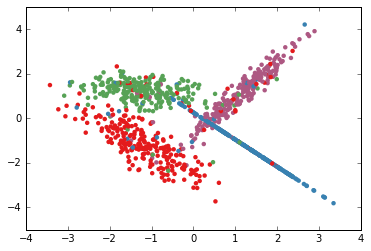

In [2]:
from sklearn.datasets import make_classification
n_classes=4
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_classes=n_classes,
                           n_clusters_per_class=1, class_sep=1.2, flip_y=0.1, random_state=1010)
cmap = mcolr.ListedColormap(plt.cm.Set1(np.linspace(0, n_classes / 10, n_classes)))
plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, edgecolors='none')

## Multilayer Perceptron

Model specifications:  
- Layout: 1 input layer (2), 1 hidden layer (2 x 10), 1 output layer (10 x 4)
- Activation functions
    * Hidden layer: $\varphi(x) = \tanh(x)$
    * Output layer: Softmax function, $\varphi(\mathbf{x})_j = \frac{e^{\mathbf{x}_j}}{\sum_{k=1}^K e^{\mathbf{x}_k}}$, where $K$ is the total number of neurons in the layer.
- Optimization objective: Cross Entropy loss function, $L_i = - \sum_j{t_{ij} \log(p_{ij})}$, where $p_{ij}$ is the prediction and $t_{ij}$ is the target.
- Optimization algorithm: Backpropagation using SGD with learning rate $\eta=0.1$, and momentum $\mu=0.9$
    ```
    velocity := momentum * velocity - learning_rate * gradient
    param := param + velocity
    ```
  $$
  \Delta w(n) := \mu\Delta w(n-1) - \eta \frac{\partial{\mathscr E(n)}}{\partial{w(n)}} \\
  w := w + \Delta w
  $$

In [3]:
import lasagne
import theano
import theano.tensor as T
from lasagne.nonlinearities import softmax, tanh
from lasagne.layers import InputLayer, DenseLayer, get_output
from lasagne.updates import sgd, apply_momentum

# ignore warnings
warnings.filterwarnings('ignore', module='lasagne')

X = X.astype(theano.config.floatX)
y = y.astype('int32')

# create perceptron layers
l_in = InputLayer(shape=X.shape)
l_hidden = DenseLayer(l_in, num_units=10, nonlinearity=tanh)
l_output = DenseLayer(l_hidden, num_units=n_classes, nonlinearity=softmax)
net_output = get_output(l_output)

# optimization objective
true_output = T.ivector('true_output')
loss = lasagne.objectives.categorical_crossentropy(net_output, true_output)
loss = loss.mean()

# optimize using sgd
params = lasagne.layers.get_all_params(l_output)
updates_sgd = sgd(loss, params, learning_rate=0.1)
updates = apply_momentum(updates_sgd, params, momentum=0.9)

# train
train = theano.function([l_in.input_var, true_output], loss, updates=updates)
get_output = theano.function([l_in.input_var], net_output)
for epoch in range(100):
    loss = train(X, y)
    if not (epoch + 1) % 10:
        print("Epoch %d: Loss %g" % (epoch + 1, loss))

Epoch 10: Loss 0.652528
Epoch 20: Loss 0.63022
Epoch 30: Loss 0.617048
Epoch 40: Loss 0.597586
Epoch 50: Loss 0.591106
Epoch 60: Loss 0.583267
Epoch 70: Loss 0.575438
Epoch 80: Loss 0.566333
Epoch 90: Loss 0.556072
Epoch 100: Loss 0.545331


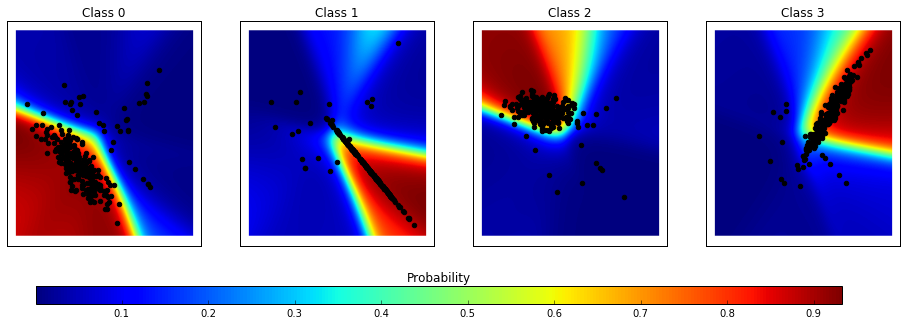

In [4]:
h = 400
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, h), np.linspace(y_min, y_max, h))
y_grid_pred = get_output(np.c_[xx.ravel(), yy.ravel()])
plt.figure(figsize=(16, 5))
for k in range(n_classes):
    plt.subplot(1, 4, k + 1)
    plt.title("Class %d" % k)
    imshow_handle = plt.imshow(y_grid_pred[:, k].reshape(xx.shape), 
                               extent=(x_min, x_max, y_min, y_max), origin='lower')
    plt.xticks(())
    plt.yticks(())
    idx = (y == k)
    plt.scatter(X[idx, 0], X[idx, 1], marker='o', c='k')
ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

## Convolutional Neural Network

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/mnist', one_hot=True)

import tensorflow as tf
sess = tf.Session()

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

sess.run(tf.initialize_all_variables())

#1st conv layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#2nd conv layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#readout layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#train model
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())
for i in range(1000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(session=sess, feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("Epoch %d, Accuracy %g" % (i, train_accuracy))
  train_step.run(session=sess, feed_dict={x: batch[0], y_: batch[1], 
                                          keep_prob: 0.5})

print("\ntest accuracy %g" % accuracy.eval(session=sess, feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

sess.close()

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz
Epoch 0, Accuracy 0.2
Epoch 100, Accuracy 0.84
Epoch 200, Accuracy 0.92
Epoch 300, Accuracy 0.86
Epoch 400, Accuracy 1
Epoch 500, Accuracy 0.9
Epoch 600, Accuracy 1
Epoch 700, Accuracy 0.98
Epoch 800, Accuracy 0.92
Epoch 900, Accuracy 1
test accuracy 0.965
